# Bayesian Posterior Analysis: Proportions

## Conjugate Priors

Bayesian analysis is based on the following relation:

$$p(\theta | D) \propto p(D | \theta) p(\theta)$$

$p(\theta)$ is the **prior** distribution of $\theta$, and $p(\theta | D)$ is the **posterior** distribution of $\theta$ after observing $D$. $p(D | \theta)$ is the **likelihood** of the evidence $D$. A **conjugate prior** is a prior distribution such that for the likelihood function $p(D | \theta)$, the posterior belongs to the same family of distributions as the prior.

[See this Wikipedia article on prior distribution](https://en.wikipedia.org/wiki/Conjugate_prior), which also includes a list of common conjugate priors.

For data that takes values of either 0 or 1, the [Beta distribution](https://en.wikipedia.org/wiki/Beta_distribution) serves as a conjugate prior. Refer to this distribution as $B(\alpha, \beta)$, and we say that the proportion of successes $p$ follows $\theta \sim B(\alpha, \beta)$. $\alpha - 1$ can be interpreted as imaginary prior "successes", and $\beta - 1$ can be interpreted as imaginary prior "failures". If $\alpha = \beta = 1$, we interpret this as there being no prior "successes" or "failures" and every probability of "success" $\theta$ is equally likely.

In [1]:
from scipy.stats import beta
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

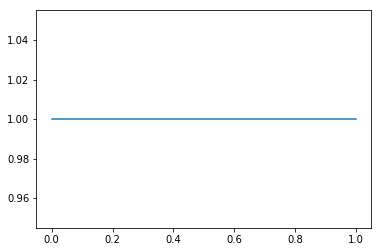

In [2]:
x = np.linspace(0, 1, num=1000)
plt.plot(x, beta.pdf(x, a=1, b=1))    # Plot of uninformative prior: the uniform distribution
plt.show()

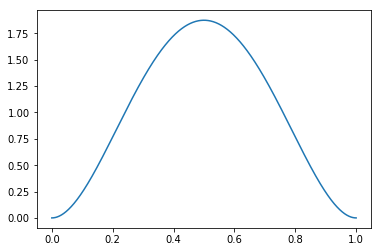

In [3]:
plt.plot(x, beta.pdf(x, a=3, b=3))    # Not an uninformative prior: has 2 "successes" and 2 "failures"
plt.show()

Suppose that in a sample of size $N$ there are $M$ "successes". Then when the prior distribution of $\theta$ is $B(\alpha, \beta)$, the posterior distribution of $\theta$ is $B(\alpha + M, \beta + N - M)$.

Let's reconsider an earlier example. Let's suppose that on a certain website, out of 1126 visitors on a given day, 310 clicked on an ad purchased by a sponsor. We will *not* use an uninformative prior; instead, our prior distribution will be $B(3, 3)$, which is interpreted as having 2 imaginary prior successes and 2 imaginary prior failure ($\theta$ is biased towards $\theta = \frac{1}{2}$, or a 50/50 chance of clicking the ad for each visitor). Then the posterior distribution of $\theta$ is $B(3 + 310, 3 + 1126 - 310) = B(313, 819)$. The prior and posterior are plotted below together to show their relationship.

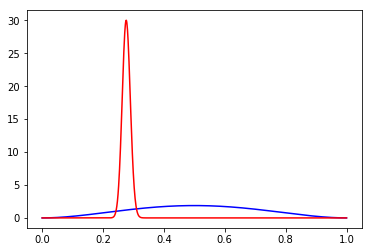

In [4]:
plt.plot(x, beta.pdf(x, a=3, b=3), 'b-')    # Prior
plt.plot(x, beta.pdf(x, a=313, b=819), 'r-')    # Posterior
plt.show()

## Credible Intervals

The Bayesian analogue to the **confidence interval** is the **credible interval**. The true value of $\theta$ has probability $C$ of lying within the $100 \times C$% credible interval. So there is a 95% chance that the true $\theta$ lies in the 95% credible interval.

A function for computing a credible interval when using the conjugate prior.

In [5]:
def bernoulli_beta_credible_interval(M, N, a=1, b=1, C=.95):
    """Computes a 100C% credible interval for Bernoulli (0/1) data
    
    args:
        M: int; number of "successes"
        N: int; total sample size
        a: float; first argument of the prior Beta distribution
        b: float; second argument of the prior Beta distribution
        C: float; the credibility (chance of containing theta) of the interval
    
    return:
        tuple; first number is the lower bound, second the upper bound, of the credible interval
    """
    
    # Error checking
    if type(M) is not int or type(N) is not int:
        raise TypeError("M, N must both be integers")
    elif M < 0 or N < M:
        raise ValueError("M, N must be non-negative, and N >= M")
    elif a <= 0 or b <= 0:
        raise ValueError("Cannot have negative prior parameters!")
    elif type(C) is not float:
        raise TypeError("C must be numeric")
    elif C < 0 or C > 1:
        raise ValueError("C must be interpretable as a probability")
    
    post = (a + M, b + N - M)
    alpha = (1 - C)/2
    return (beta.ppf(alpha, post[0], post[1]), beta.ppf(1 - alpha, post[0], post[1]))

In [6]:
bernoulli_beta_credible_interval(310, 1126)

(0.2500262564237963, 0.3021454985368043)

In [7]:
bernoulli_beta_credible_interval(310, 1126, a=3, b=3)

(0.25083904055649237, 0.3029124943404833)

In [8]:
bernoulli_beta_credible_interval(310, 1126, a=3, b=3, C=.99)    # Like with confidence intervals,
                                                                # larger C -> larger interval

(0.24304349518931037, 0.31144211849989634)

## Hypothesis Testing

Bayesian hypothesis testing is merely computing the probability that $\theta$ lies within the interval of interest.

For instance, suppose that the administrator of the website you're testing claims that at least 30% of visitors to the site click the ad. What is the probability that the administrator is correct?

We use the **cumulative distribution function (CDF)** of the posterior distribution to answer this question. The CDF is defined as $F(x) = P(X \leq x)$. Notice $P(X > x) = 1 - F(x)$. Here, we want $P(\theta > .3 | D)$.

In [9]:
1 - beta.cdf(.3,    # Coincides with the administrator's claim
             a=3 + 310,    # Posterior a
             b=3 + 1126 - 310)    # Posterior b

0.040212562023420606

There is only a small probability that the administrator is correct. (Note, though, that this cannot be interpreted the same way as a p-value!)

## Comparing Two Proportions

The website is trying two different ad formats, format A and format B. Users are randomly assigned to one format or the other, and the website tracks how many viewers click the ad in the different formats. The website wants to know whether format B leads to more clicks than format A.

Here we want the *joint* posterior distribution for $\theta_A$ and $\theta_B$, but this is not easy to compute and getting the probability that $\theta_A < \theta_B$ is also hard. So we do the following:

1. Assume that $\theta_A$ and $\theta_B$ are independent.
2. Collect data and compute the posterior distributions for $\theta_A$ and $\theta_B$ separately.
3. Simulate $\theta_A$ and $\theta_B$, randomly sampling from their posterior distributions.
4. Compute the proportion of times that $\theta_A < \theta_B$.

516 visitors saw format A, and 108 of them clicked the ad. 510 visitors saw format B, and 144 of them clicked the ad. If the prior distribution for both $\theta_A$ and $\theta_B$ is $B(3, 3)$, then the posterior distribution for $\theta_A$ is then $B(111, 411)$, and for $\theta_B$, $B(147, 369)$. They're visualized below.

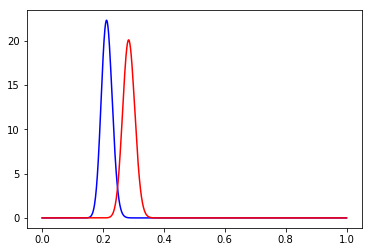

In [10]:
plt.plot(x, beta.pdf(x, 111, 411), 'b-')    # Posterior distribution for theta_A
plt.plot(x, beta.pdf(x, 147, 369), 'r-')    # Posterior distribution for theta_B
plt.show()

Now we engage in the simulation to see how often $\theta_A < \theta_B$.

In [11]:
# Demonstration: A random theta_A
beta.rvs(111, 411)

0.1929969121939489

In [12]:
# A random theta_B
beta.rvs(147, 369)

0.27709268944058973

In [13]:
N = 1000    # Number of simulations
random_A = beta.rvs(111, 411, size=N)
random_B = beta.rvs(147, 369, size=N)

In [14]:
random_A[0:10]

array([0.21260757, 0.19883927, 0.21481813, 0.22372305, 0.2345362 ,
       0.20883586, 0.17762284, 0.18868159, 0.20047948, 0.2153835 ])

In [15]:
random_B[0:10]

array([0.28291041, 0.25742364, 0.26818903, 0.30192973, 0.28515708,
       0.2918938 , 0.28894111, 0.29839457, 0.31805331, 0.25803755])

In [16]:
random_A[0:10] < random_B[0:10]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [17]:
trial = random_A < random_B
trial.sum()    # Number of times theta_A < theta_B

997

In [18]:
trial.mean()    # Estimated probability theta_A < theta_B

0.997

There is a high probability that $\theta_A < \theta_B$ according to our simulation.